In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import pandas as pd
import cv2
import matplotlib.image as mpimg
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LayerNormalization, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
import graphviz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run: Local
folder_link = ""

In [ ]:
# Run: Darren
folder_link = "/content/drive/My Drive/comp4211/project/"

In [ ]:
# Run: Newt
folder_link = "/content/drive/My Drive/HKUST/COMP 4211/Project/"

In [ ]:
os.listdir(f"{folder_link}image_data/adausdt")
# os.listdir('/content/drive/My Drive/HKUST/COMP 4211/Project/image_data/adausdt')

['validation_output.csv',
 'validation_data.dat',
 'training_output.csv',
 'training_data.dat',
 'testing_output.csv',
 'testing_data.dat']

## Data Processing

In [ ]:
train_data = np.load(f"{folder_link}image_data/train_data.npz")["arr_0"]
train_output = pd.read_csv(f"{folder_link}image_data/train_output.csv")
test_data = np.load(f"{folder_link}image_data/test_data.npz")["arr_0"]
test_output = pd.read_csv(f"{folder_link}image_data/test_output.csv")

In [ ]:
train_output

,Open time,LogReturns,NormalizedLR
0,1609545600000,-0.019493,-0.206317
1,1609549200000,0.010832,0.114642
2,1609552800000,0.004025,0.042597
3,1609556400000,0.004180,0.044241
4,1609560000000,-0.004065,-0.043026
...,...,...,...
280432,1711908000000,0.002394,0.105351
280433,1711911600000,0.002229,0.113083
280434,1711915200000,-0.002070,-0.104998
280435,1711918800000,-0.000638,-0.032351


(54, 72)


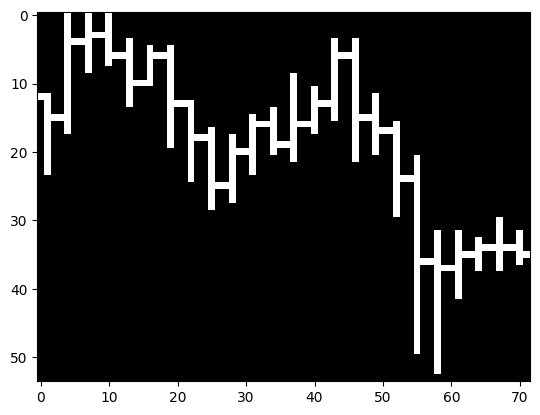

In [ ]:
sample = train_data[0]
print(sample.shape)
plt.figure()
plt.imshow(sample, cmap="gray")

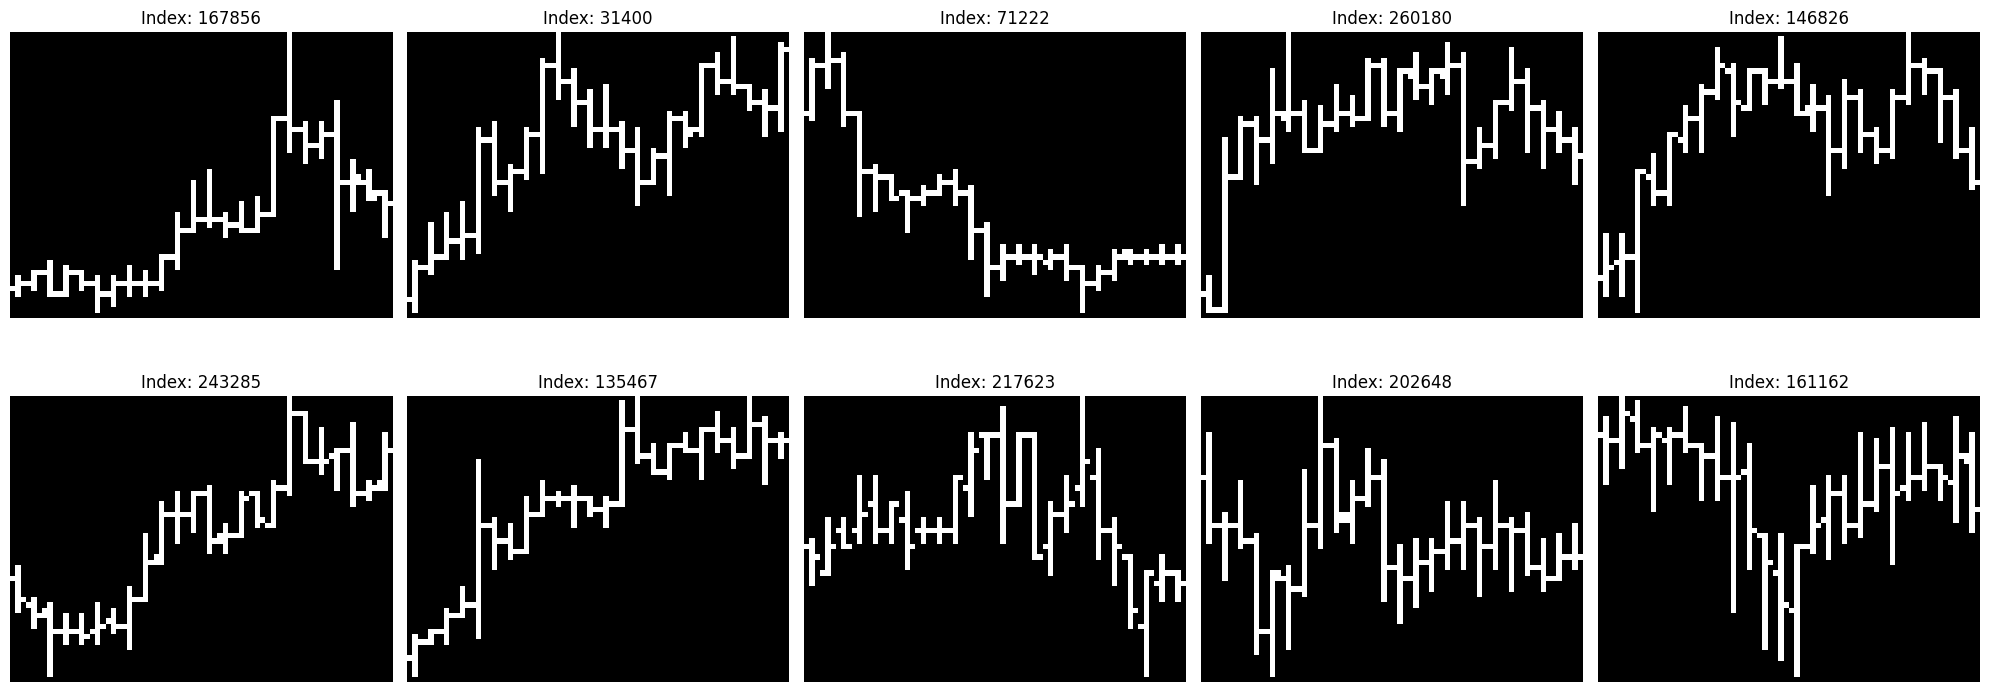

In [ ]:
# Plot 10 random images and print their indices
fig, axs = plt.subplots(2, 5, figsize = (20, 8))
for i in range(10):
    index = np.random.randint(0, train_data.shape[0])
    axs[i // 5, i % 5].imshow(train_data[index], cmap = "gray")
    axs[i // 5, i % 5].set_title(f"Index: {index}")
    axs[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()

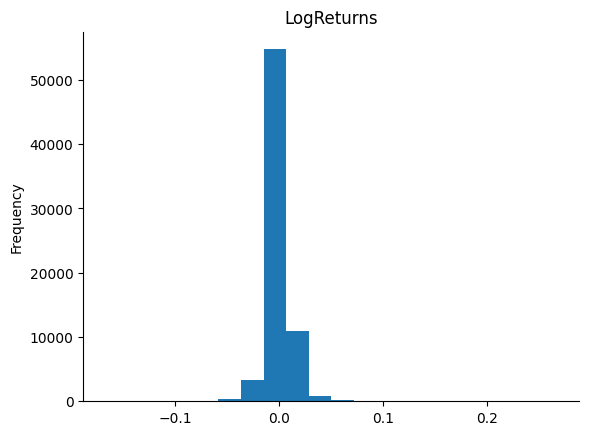

In [ ]:
test_output['LogReturns'].plot(kind='hist', bins=20, title='LogReturns')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
scaler = StandardScaler()
test_output[["NormalizedLR"]] = scaler.fit_transform(test_output[["NormalizedLR"]])

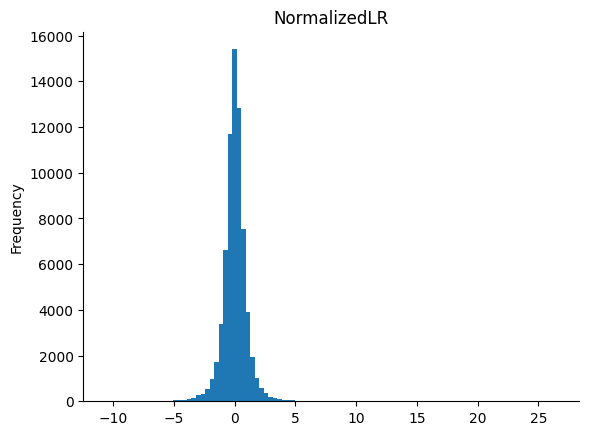

In [ ]:
test_output['NormalizedLR'].plot(kind='hist', bins=100, title='NormalizedLR')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
test_output['NormalizedLR'].describe()

,NormalizedLR
count,7.029700e+04
mean,1.061311e-18
std,1.000007e+00
min,-1.061107e+01
25%,-4.639482e-01
50%,1.204764e-02
75%,4.715858e-01
max,2.651343e+01


## Model

In [ ]:
# class CustomPnlLoss(tf.keras.losses.Loss):
#     def __init__(self, penalty_multiplier=0.001, name="custom_pnl_loss"):
#         super().__init__(name=name)
#         self.penalty_multiplier = penalty_multiplier

#     def call(self, y_true, y_pred):
#         direction_pred = tf.sign(y_pred)
#         confidence = tf.clip_by_value(tf.abs(y_pred), 0, 1)
#         trade_amounts = confidence

#         long_pnl = tf.where(direction_pred == 1.0, y_true * trade_amounts, tf.zeros_like(y_true))
#         short_pnl = tf.where(direction_pred == -1.0, -y_true * trade_amounts, tf.zeros_like(y_true))
#         total_pnl = long_pnl + short_pnl

#         loss = -total_pnl
#         penalty = tf.where(loss < 0, self.penalty_multiplier * confidence, tf.zeros_like(loss))
#         total_loss = tf.reduce_mean(loss) + tf.reduce_mean(penalty)

#         return total_loss

#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             'penalty_multiplier': self.penalty_multiplier,
#         })
#         return config

class CustomPnlLoss(tf.keras.losses.Loss):
    def __init__(self, penalty_multiplier=0.000, reduction=None, name="custom_pnl_loss"):
        super().__init__(reduction=None, name=name)
        self.penalty_multiplier = penalty_multiplier

    def call(self, y_true, y_pred):
        direction_pred = tf.sign(y_pred)
        trade_amounts = tf.clip_by_value(tf.abs(y_pred), 0, 1)
        # trade_amounts = tf.abs(y_pred)

        long_pnl = tf.where(direction_pred == 1.0, y_true * trade_amounts, tf.zeros_like(y_true))
        short_pnl = tf.where(direction_pred == -1.0, -y_true * trade_amounts, tf.zeros_like(y_true))
        total_pnl = long_pnl + short_pnl

        loss = -total_pnl
        penalty = tf.where(loss < 0, self.penalty_multiplier * trade_amounts, tf.zeros_like(loss))
        total_loss = tf.reduce_mean(loss) + tf.reduce_mean(penalty)

        return total_loss

    def get_config(self):
        config = super().get_config()
        config.update({
            'penalty_multiplier': self.penalty_multiplier,
        })
        return config

# model.save("model.h5")
# model = keras.models.load_model("model.h5", custom_objects={'custom_pnl_loss': CustomPnlLoss()})

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 54, 72, 32)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 54, 72, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 54, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 72, 64)          │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 27, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 27, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 72, 128)         │         123,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 72, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 13, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 72, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 72, 256)          │         491,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 72, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 6, 72, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 72, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 72, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 55296)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,078,016 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,742,657 (29.54 MB)

 Trainable params: 7,741,697 (29.53 MB)

 Non-trainable params: 960 (3.75 KB)

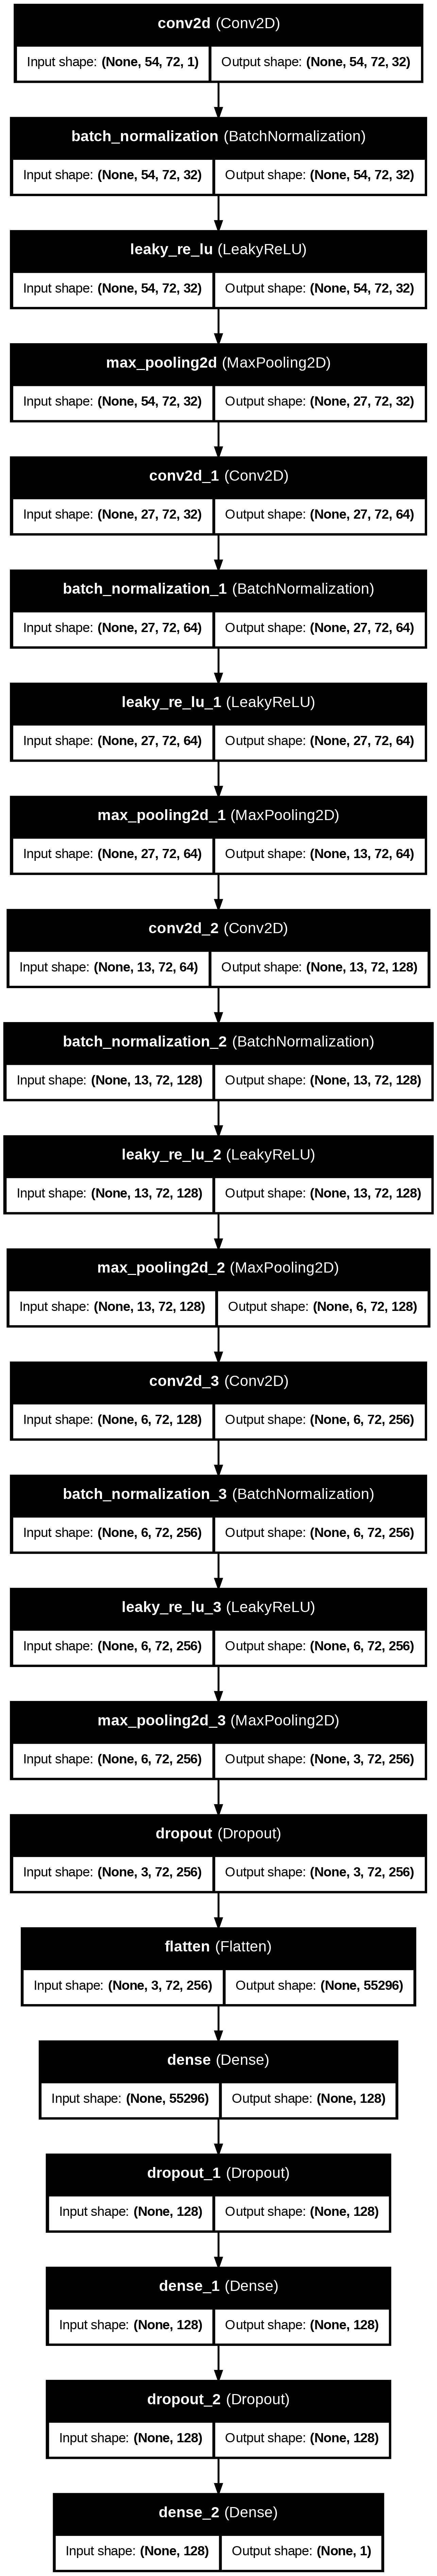

In [ ]:
model = Sequential([
    # Layer 1
    Conv2D(32, kernel_size=(5, 3), padding='same', dilation_rate=(3, 1), input_shape=(54, 72, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(2, 1)),

    # Layer 2
    Conv2D(64, kernel_size=(5, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(2, 1)),

    # Layer 3
    Conv2D(128, kernel_size=(5, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(2, 1)),

    # Layer 4
    Conv2D(256, kernel_size=(5, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.5),

    # Fully connected layer
    Flatten(),
    Dense(128),
    Dropout(0.5),
    Dense(128),
    Dropout(0.5),
    Dense(1)
])
# Create an instance of the custom loss
custom_loss = CustomPnlLoss()

# Compile the model with the custom loss
model.compile(optimizer='adam', loss=custom_loss)
model.summary()

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# # Custom loss function class
# class CustomPnlLoss(tf.keras.losses.Loss):
#     def __init__(self, penalty_multiplier=0.001, reduction=None, name="custom_pnl_loss"):
#         super().__init__(reduction=None, name=name)
#         self.penalty_multiplier = penalty_multiplier

#     def call(self, y_true, y_pred):
#         direction_pred = tf.sign(y_pred)
#         confidence = tf.clip_by_value(tf.abs(y_pred), 0, 1)
#         trade_amounts = confidence

#         long_pnl = tf.where(direction_pred == 1.0, y_true * trade_amounts, tf.zeros_like(y_true))
#         short_pnl = tf.where(direction_pred == -1.0, -y_true * trade_amounts, tf.zeros_like(y_true))
#         total_pnl = long_pnl + short_pnl

#         loss = -total_pnl
#         penalty = tf.where(loss < 0, self.penalty_multiplier * confidence, tf.zeros_like(loss))
#         total_loss = tf.reduce_mean(loss) + tf.reduce_mean(penalty)

#         return total_loss

#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             'penalty_multiplier': self.penalty_multiplier,
#         })
#         return config

# # Generate synthetic data
# X_train = np.random.rand(1000, 10)
# y_train = np.random.rand(1000, 1)
# X_val = np.random.rand(200, 10)
# y_val = np.random.rand(200, 1)

# # Build the FNN model
# model = keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(10,)),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(1)  # Output layer
# ])

# # Create an instance of the custom loss
# custom_loss = CustomPnlLoss(penalty_multiplier=0.001)

# # Compile the model with the custom loss
# model.compile(optimizer='adam', loss=custom_loss)

# # Train the model
# # history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

# # Save the model
# model.save('my_model_with_custom_loss.h5')

# # Load the model with the custom loss function
# loaded_model = keras.models.load_model('my_model_with_custom_loss.h5', custom_objects={'CustomPnlLoss': CustomPnlLoss})

# # Optionally, test the loaded model
# # X_test = np.random.rand(5, 10)  # 5 new samples
# # predictions = loaded_model.predict(X_test)

# # print("Predictions:", predictions)

In [ ]:
# model.save('model.h5')

# # Load the model with the custom loss function
# loaded_model = keras.models.load_model('model.h5', custom_objects={'CustomPnlLoss': CustomPnlLoss})

In [ ]:
X = train_data.reshape((-1, 54, 72, 1))
y = train_output["NormalizedLR"].values
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X, y, epochs=10, validation_split=0.2, shuffle=True, callbacks=[early_stopping])

model.save('model.h5')

# Load the model with the custom loss function
loaded_model = keras.models.load_model('model.h5', custom_objects={'CustomPnlLoss': CustomPnlLoss})

Epoch 1/10
7011/7011 ━━━━━━━━━━━━━━━━━━━━ 221s 30ms/step - loss: 8.7889e-04 - val_loss: 3.7840e-05
Epoch 2/10
7011/7011 ━━━━━━━━━━━━━━━━━━━━ 251s 30ms/step - loss: 3.0589e-04 - val_loss: 3.7840e-05
Epoch 3/10
7011/7011 ━━━━━━━━━━━━━━━━━━━━ 256s 29ms/step - loss: 6.5694e-04 - val_loss: 3.7840e-05
Epoch 4/10
7011/7011 ━━━━━━━━━━━━━━━━━━━━ 201s 29ms/step - loss: 5.8554e-04 - val_loss: 3.7840e-05


In [ ]:
# Make predictions
X_train = train_data.reshape((-1, 54, 72, 1))
y_pred = model.predict(X_train)

# # Calculate the loss
# loss = np.mean((y_pred - train_output["NormalizedLR"].values) ** 2)
# print(f"Loss: {loss}")

# # Compare loss against benchmark
# benchmark_loss = np.mean((train_output["NormalizedLR"].values) ** 2)
# print(f"Benchmark Loss: {benchmark_loss}")

8764/8764 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step


In [ ]:
y_pred.shape

(280437, 1)

In [ ]:
y_pred

array([[-593.9951 ],
       [-585.9023 ],
       [-580.0103 ],
       ...,
       [-617.4888 ],
       [-612.5925 ],
       [-609.10425]], dtype=float32)

In [ ]:
pd.DataFrame(y_pred).describe()

,0
count,280437.000000
mean,-615.913513
std,44.324425
min,-758.769653
25%,-647.531189
50%,-618.407715
75%,-587.220886
max,-370.491058


In [ ]:
train_output["NormalizedLR"].describe()

,NormalizedLR
count,280437.000000
mean,-0.000357
std,0.155496
min,-3.636773
25%,-0.069578
50%,0.000000
75%,0.070558
max,11.028772


In [ ]:
# train_output["NormalizedLogReturns"]

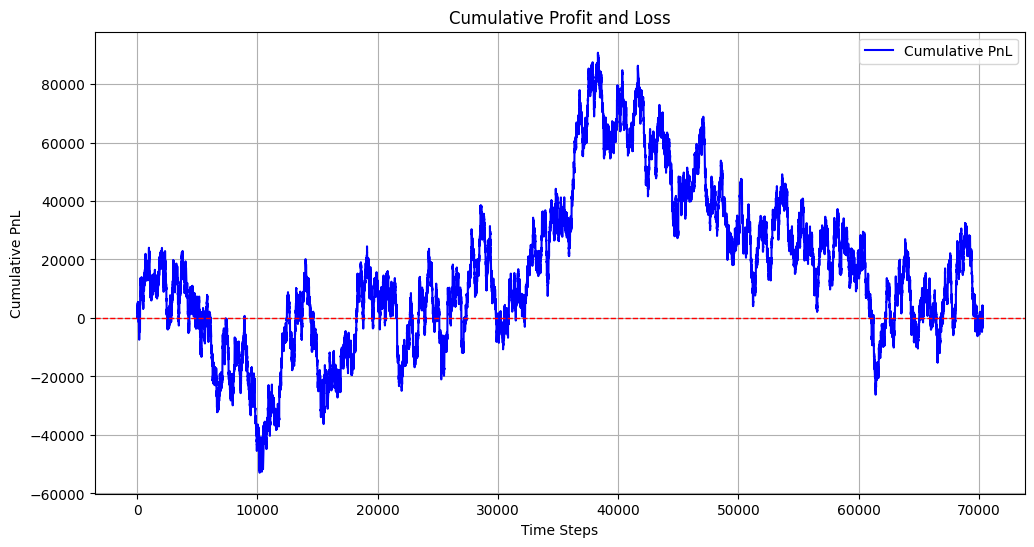

In [ ]:
# # Assuming model is already loaded and X_test is prepared
# X_test = test_data.reshape((-1, 54, 72, 1))
# y_pred = model.predict(X_test)

predicted_directions = np.sign(y_pred)  # Predicted direction (0 or 1)
predicted_confidences = np.abs(y_pred)  # Confidence level

actual_changes = test_output["NormalizedLR"].values

pnl = []
for direction, confidence, change in zip(predicted_directions, predicted_confidences, actual_changes):
    pnl_value = change if direction == 1 else -change
    weighted_pnl = pnl_value * confidence
    pnl.append(weighted_pnl)
pnl = np.array(pnl)
cumulative_pnl = np.cumsum(pnl)

# Plot cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(cumulative_pnl, label='Cumulative PnL', color='blue')
plt.title('Cumulative Profit and Loss')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative PnL')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Draw line at y=0 for reference
plt.legend()
plt.grid()
plt.show()

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


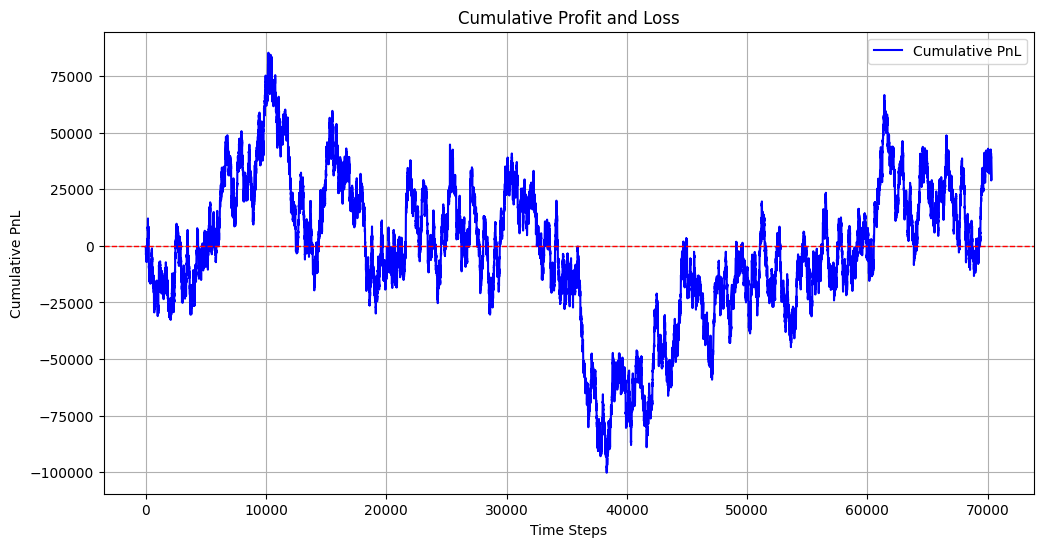

In [ ]:
# Assuming model is already loaded and X_test is prepared
X_test = test_data.reshape((-1, 54, 72, 1))
y_pred = model.predict(X_test)

predicted_directions = np.round(y_pred[:, 0])  # Predicted direction (0 or 1)
predicted_confidences = y_pred[:]  # Confidence level

actual_changes = test_output["NormalizedLR"].values

pnl = []
for direction, confidence, change in zip(predicted_directions, predicted_confidences, actual_changes):
    pnl_value = change if direction == 1 else -change
    weighted_pnl = pnl_value * confidence
    pnl.append(weighted_pnl)
pnl = np.array(pnl)
cumulative_pnl = np.cumsum(pnl)

# Plot cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(cumulative_pnl, label='Cumulative PnL', color='blue')
plt.title('Cumulative Profit and Loss')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative PnL')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Draw line at y=0 for reference
plt.legend()
plt.grid()
plt.show()

In [ ]:
# X_test = test_data.reshape((-1, 54, 72, 1))
# y_pred = model.predict(X_test).flatten()

# # Calculate the loss
# loss = np.mean((y_pred - test_output["NormalizedLR"].values) ** 2)
# print(f"Loss: {loss}")

# # Compare loss against benchmark
# benchmark_loss = np.mean((test_output["NormalizedLR"].values) ** 2)
# print(f"Benchmark Loss: {benchmark_loss}")

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
Loss: 0.05749589267666084
Benchmark Loss: 0.05748831188406694


In [ ]:
y_pred.shape

(70297,)

In [ ]:
test_output["NormalizedLogReturns"].shape

(70297,)

In [ ]:
np.sign(y_pred).shape

(70297,)

In [ ]:
# Plot the PnL if you buy/sell depending on the prediction
pnl = np.cumsum(np.array(np.sign(y_pred) * test_output["LogReturns"]))
plt.figure()
plt.plot(pnl)
plt.title("PnL")
plt.show()

NameError: name 'np' is not defined

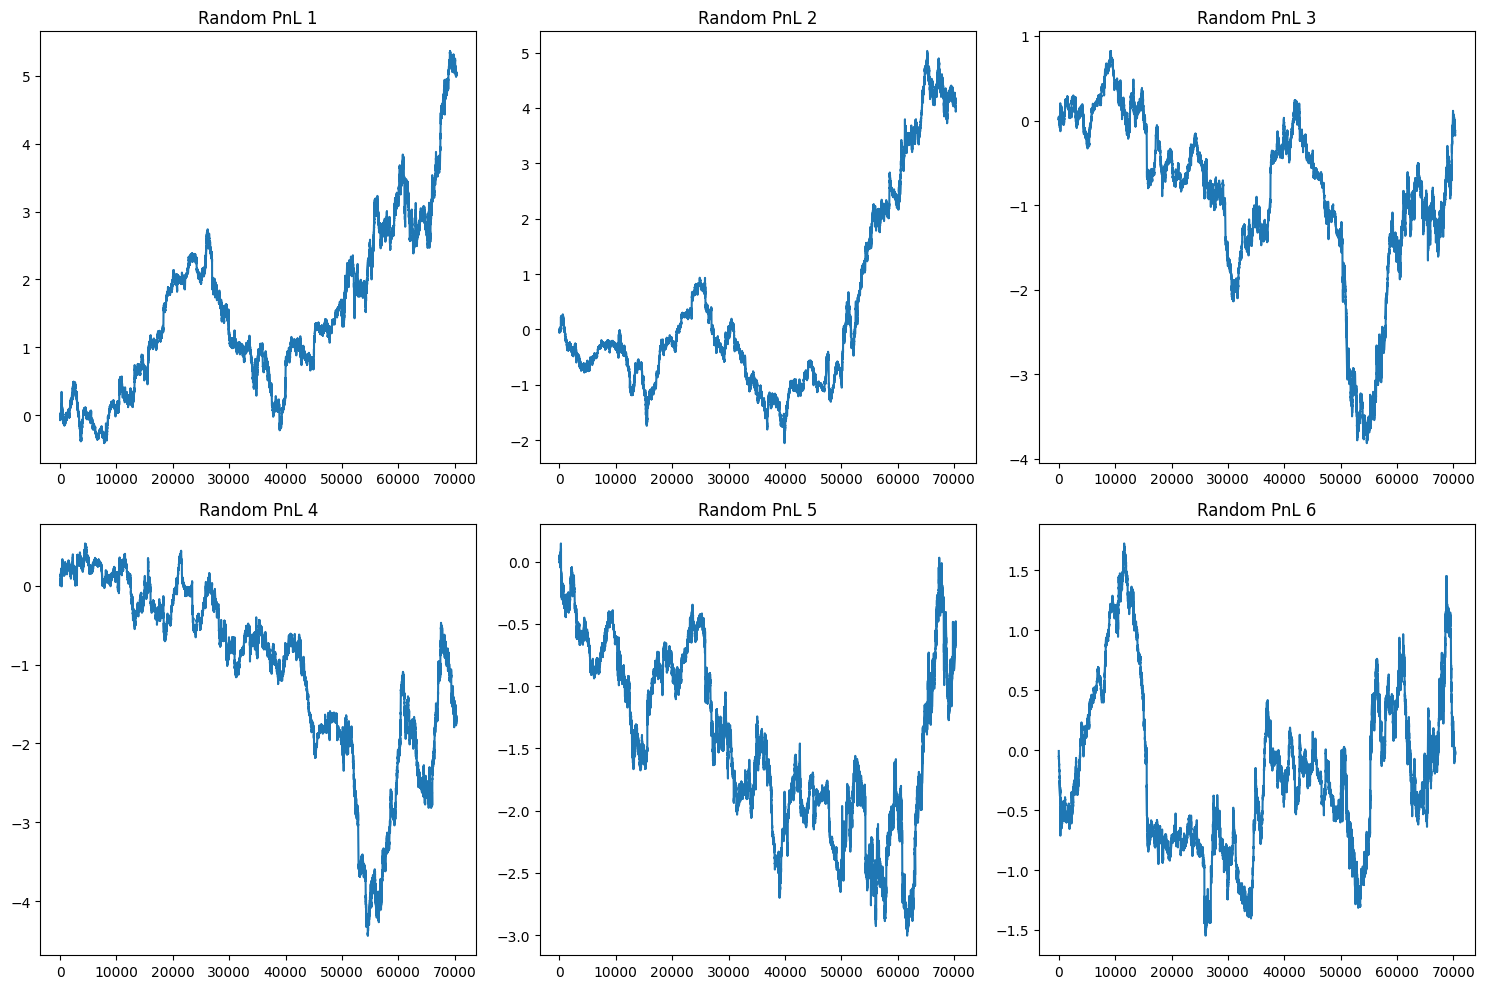

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    random_signals = np.sign(np.random.random(len(test_output)) - 0.5)
    pnl = np.cumsum(np.array(random_signals * test_output["LogReturns"]))
    axs[i // 3, i % 3].plot(pnl)
    axs[i // 3, i % 3].set_title(f"Random PnL {i+1}")
plt.tight_layout()
plt.show()